In [1]:
import os
from functools import reduce

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import patchworklib as pw
import pingouin as pg
import seaborn as sns
import xarray as xr

plt.style.use("papers")
pw.overwrite_axisgrid()

COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]

DATA_ORDER = ["real data", "shuffle", "FT", "AAFT", "IAAFT"]

FOLDER = "../../results/aggregated/"


# DATA_TYPE = "real_data"
EOC = "EC"

<Figure size 72x72 with 0 Axes>

In [2]:
stats = pd.read_csv(os.path.join(FOLDER, "stats.csv"))
stats = stats[(stats["data_type"] == EOC)]
stats = stats.rename(columns={"decomposition_type": "algorithm"}).replace(
    {"hmm": "HMM", "kmeans": "mod. K-Means", "real_data": "real data"}
)
stats = stats.sort_values(by=["algorithm", "data_type", "surrogate_type"])

In [3]:
stats = (
    stats.rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .set_index("surrogate_type")
    .loc[DATA_ORDER]
    .reset_index()
)
stats_melt = stats.melt(
    id_vars=["algorithm", "latent map", "surrogate_type"],
    value_vars=["coverage", "lifespan", "occurrence"],
)
stats_melt

,algorithm,latent map,surrogate_type,variable,value
0,AAHC,A,real data,coverage,0.257715
1,AAHC,B,real data,coverage,0.216156
2,AAHC,C,real data,coverage,0.243935
3,AAHC,D,real data,coverage,0.282194
4,AAHC,A,real data,coverage,0.248035
...,...,...,...,...,...
73075,ICA,D,IAAFT,occurrence,12.063807
73076,ICA,A,IAAFT,occurrence,12.799795
73077,ICA,B,IAAFT,occurrence,12.779796
73078,ICA,C,IAAFT,occurrence,12.959793


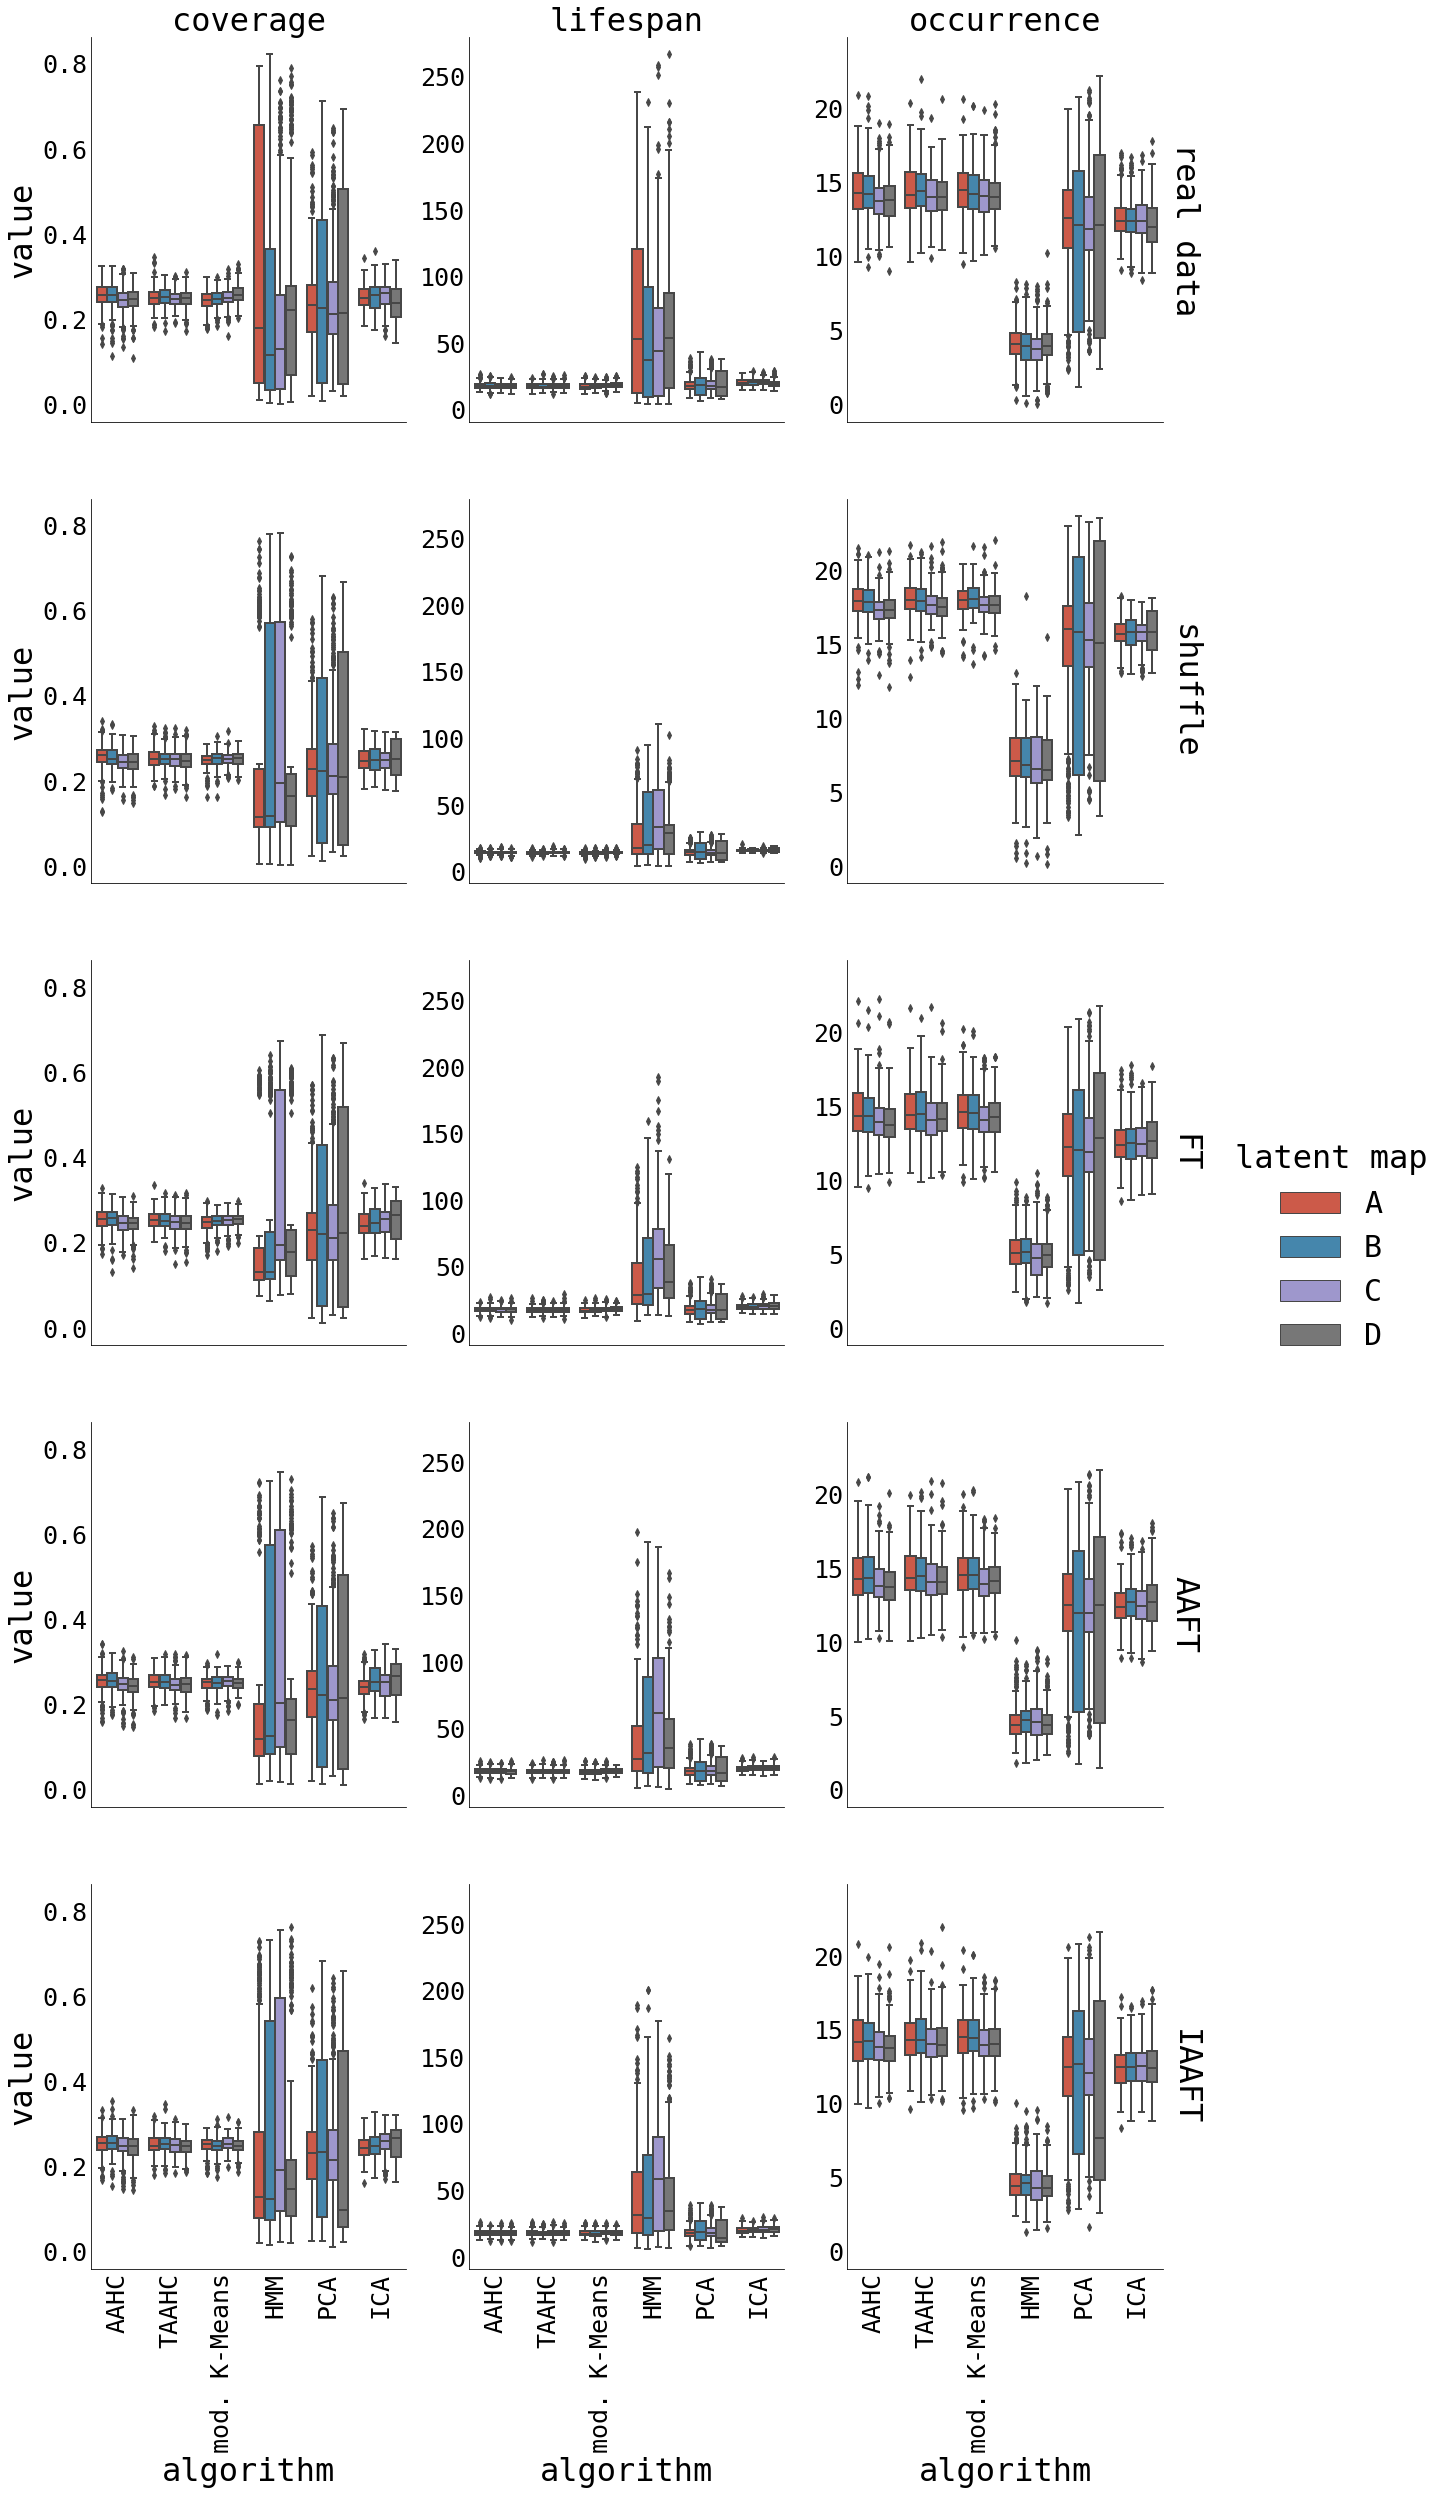

In [4]:
g = sns.catplot(
    data=stats_melt,
    x="algorithm",
    y="value",
    hue="latent map",
    hue_order=["A", "B", "C", "D"],
    col="variable",
    row="surrogate_type",
    sharex=True,
    sharey="col",
    margin_titles=True,
    kind="box",
    aspect=0.8,
    height=6.2,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_xticklabels(rotation=90)
# g.axes[0][0].text(
#     -0.1,
#     1.15,
#     "A",
#     ha="center",
#     va="center",
#     transform=g.axes[0][0].transAxes,
#     fontsize=70,
# )
g1 = pw.load_seaborngrid(g)
g1.savefig(quick=True)

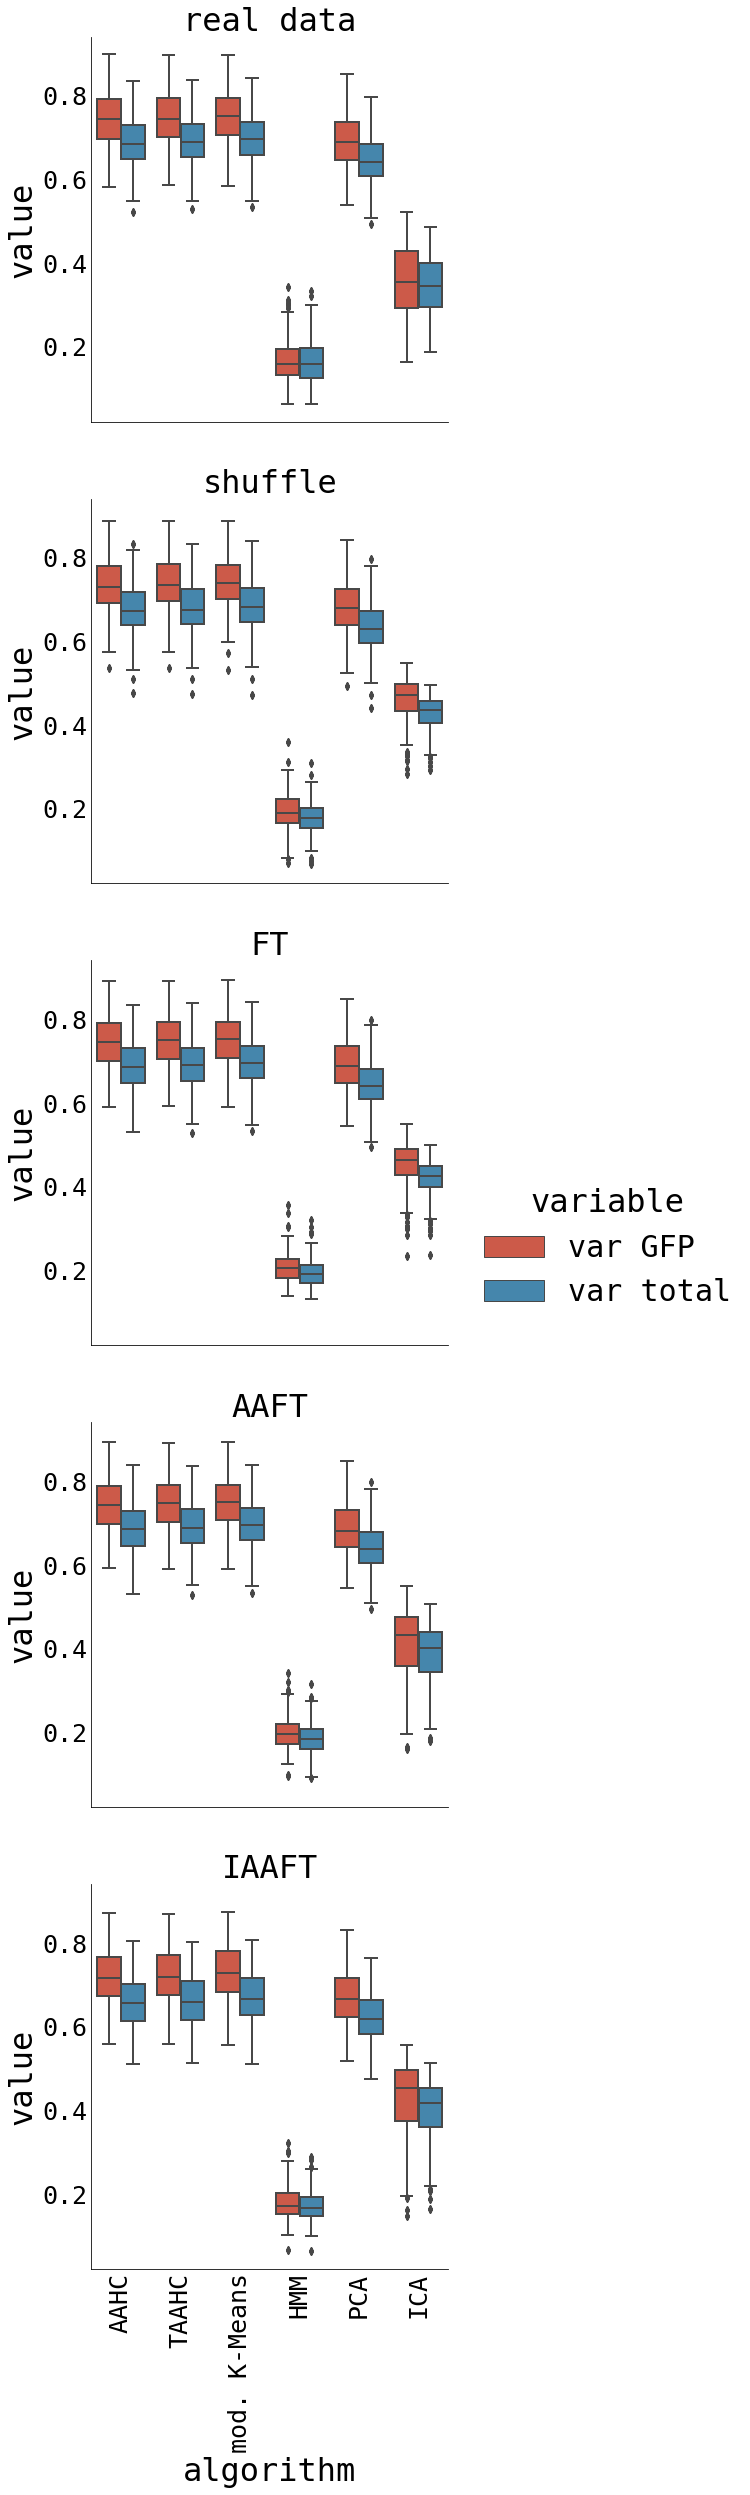

In [5]:
g = sns.catplot(
    data=stats.melt(
        id_vars=["algorithm", "surrogate_type"], value_vars=["var GFP", "var total"]
    ),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
    row="surrogate_type",
    aspect=0.8,
    height=6.2,
    sharey="col",
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_xticklabels(rotation=90)
# g.axes[0][0].text(
#     -0.1,
#     1.15,
#     "B",
#     ha="center",
#     va="center",
#     transform=g.axes[0][0].transAxes,
#     fontsize=70,
# )
g2 = pw.load_seaborngrid(g)
g2.savefig(quick=True)

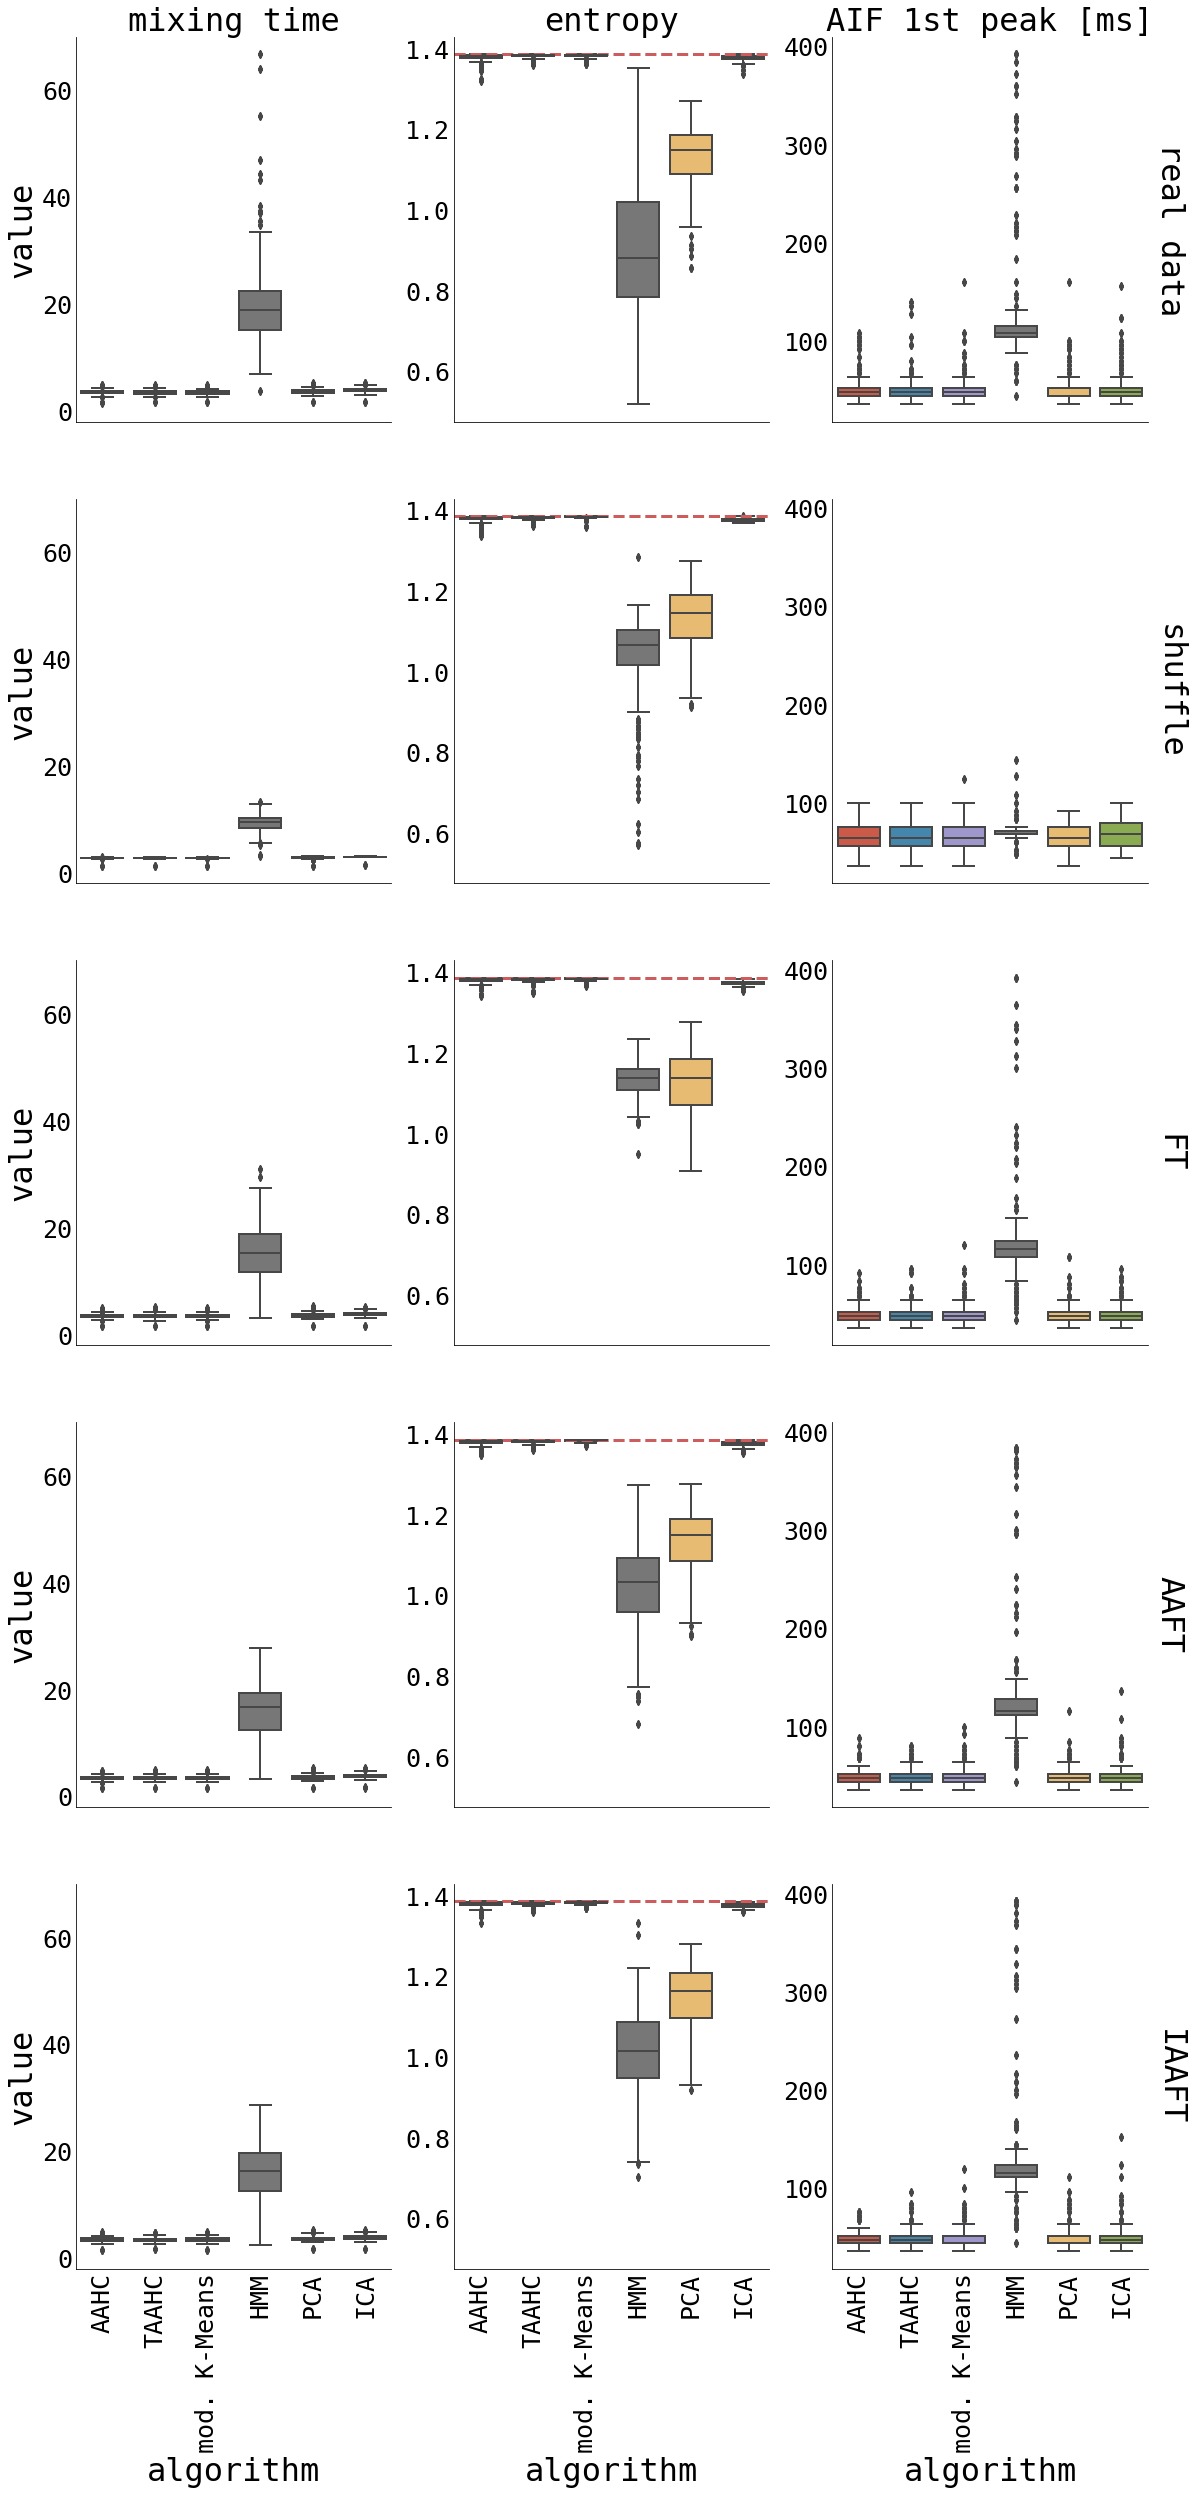

In [6]:
dynstats_melt = (
    stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .set_index("surrogate_type")
    .loc[DATA_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm", "surrogate_type"],
        value_vars=["mixing time", "entropy", "AIF 1st peak [ms]"],
    )
)
g = sns.catplot(
    data=dynstats_melt,
    x="algorithm",
    y="value",
    col="variable",
    row="surrogate_type",
    sharex=True,
    sharey="col",
    margin_titles=True,
    kind="box",
    aspect=0.8,
    height=6.2,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_xticklabels(rotation=90)
for ax in g.axes[:, 1]:
    ax.axhline(
        stats["max entropy"].unique()[0],
        linestyle="--",
        color="indianred",
        linewidth=3.0,
    )
# g.axes[0][0].text(
#     -0.1,
#     1.15,
#     "C",
#     ha="center",
#     va="center",
#     transform=g.axes[0][0].transAxes,
#     fontsize=70,
# )

g3 = pw.load_seaborngrid(g)
g3.savefig(quick=True)

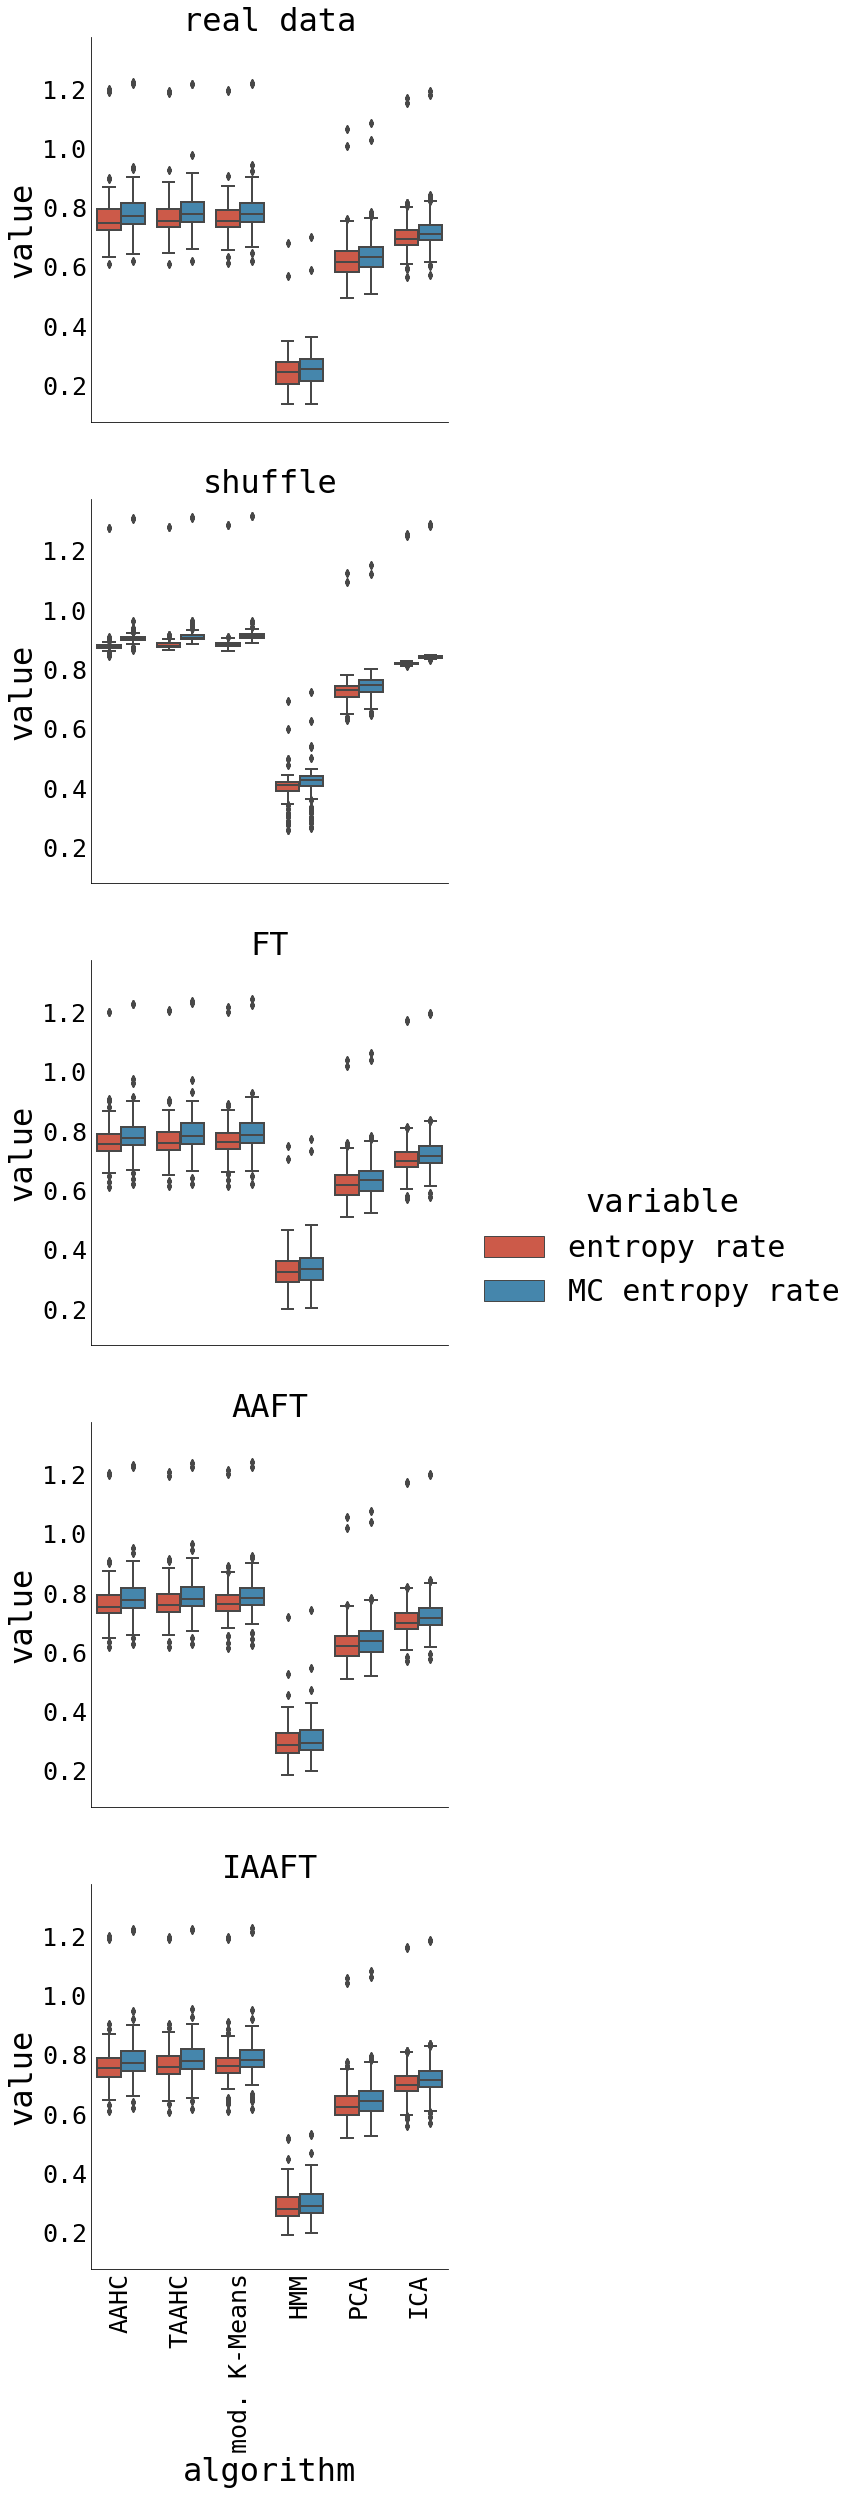

In [7]:
g = sns.catplot(
    data=stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .set_index("surrogate_type")
    .loc[DATA_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm", "surrogate_type"],
        value_vars=["entropy rate", "MC entropy rate"],
    ),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
    sharey="col",
    aspect=0.8,
    height=6.2,
    row="surrogate_type",
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_xticklabels(rotation=90)
# g.axes[0][0].text(
#     -0.1,
#     1.15,
#     "D",
#     ha="center",
#     va="center",
#     transform=g.axes[0][0].transAxes,
#     fontsize=70,
# )

g4 = pw.load_seaborngrid(g)
g4.savefig(quick=True)

In [8]:
subj_topo = (
    xr.open_dataarray(os.path.join(FOLDER, "topomaps.nc"))
    .squeeze()
    .sel({"data_type": EOC})
    .rename({"decomposition_type": "algorithm"})
)
rename_algs = {
    "AAHC": "AAHC",
    "TAAHC": "TAAHC",
    "ICA": "ICA",
    "PCA": "PCA",
    "hmm": "HMM",
    "kmeans": "mod. K-Means",
}
subj_topo["algorithm"] = [
    rename_algs[str(alg.values)] for alg in subj_topo["algorithm"]
]
subj_topo = subj_topo.stack(algo_surr=("surrogate_type", "algorithm"))

In [9]:
all_corrs = []
for alg1 in subj_topo["algo_surr"]:
    for alg2 in subj_topo["algo_surr"]:
        for map1 in subj_topo["latent map"]:
            for map2 in subj_topo["latent map"]:
                corrs = (
                    xr.corr(
                        subj_topo.sel({"algo_surr": alg1, "latent map": map1}),
                        subj_topo.sel({"algo_surr": alg2, "latent map": map2}),
                        dim="channels",
                    )
                    .assign_coords(
                        {"alg1": alg1, "alg2": alg2, "map1": map1, "map2": map2}
                    )
                    .expand_dims(["alg1", "alg2", "map1", "map2"])
                )
                all_corrs.append(corrs)
all_corrs = np.abs(xr.combine_by_coords(all_corrs))

In [10]:
all_corrs

<xarray.DataArray (alg1: 30, alg2: 30, map1: 4, map2: 4, subject_id: 203)>
array([[[[[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
           1.00000000e+00,            nan, 1.00000000e+00],
          [5.40020682e-01, 4.28781668e-01, 1.94356268e-01, ...,
           1.97044103e-01, 0.00000000e+00, 7.91042076e-01],
          [7.67373109e-01, 4.46667034e-01, 7.05444971e-01, ...,
           7.75491097e-01,            nan, 8.77426146e-01],
          [3.53605777e-01, 8.38352864e-01, 4.45209791e-01, ...,
           5.85845885e-01, 0.00000000e+00, 8.33715917e-01]],

         [[5.40020682e-01, 4.28781668e-01, 1.94356268e-01, ...,
           1.97044103e-01, 0.00000000e+00, 7.91042076e-01],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [6.65949135e-02, 6.51304259e-01, 5.55914258e-01, ...,
           7.25711839e-01, 0.00000000e+00, 9.33700498e-01],
          [5.95022365e-01, 7.44740401e-01, 5.94308451e-01, ...,
           8.51541264e-01, 6.95668395e-01, 9.13463272e-01]],

         [[7.67373109e-01, 4.46667034e-01, 7.05444971e-01, ...,
           7.75491097e-01,            nan, 8.77426146e-01],
...
          [5.64691486e-01, 5.60831058e-01, 3.67557535e-01, ...,
           6.16510462e-01, 4.73045945e-01, 7.71681751e-01]],

         [[6.45004132e-01, 2.97306537e-01, 6.06417517e-01, ...,
           6.28720671e-01, 6.14744407e-01, 8.06003182e-01],
          [7.33064238e-02, 7.21968965e-01, 4.66871149e-01, ...,
           6.66354715e-01, 6.12307104e-01, 5.08067825e-01],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [5.89422004e-01, 1.45092326e-01, 6.84932024e-01, ...,
           8.68104021e-01, 7.48227003e-01, 8.80052826e-01]],

         [[5.04255960e-01, 2.18179448e-02, 4.22929844e-01, ...,
           7.27038273e-01, 5.69245037e-01, 8.76753262e-01],
          [5.64691486e-01, 5.60831058e-01, 3.67557535e-01, ...,
           6.16510462e-01, 4.73045945e-01, 7.71681751e-01],
          [5.89422004e-01, 1.45092326e-01, 6.84932024e-01, ...,
           8.68104021e-01, 7.48227003e-01, 8.80052826e-01],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00]]]]])
Coordinates:
  * subject_id  (subject_id) object 'sub-010002' 'sub-010003' ... 'sub-010321'
    latent map  (map2) <U1 'A' 'B' 'C' 'D'
    no_states   int64 4
    data_type   <U2 'EC'
    algo_surr   (alg2) object ('AAFT', 'AAHC') ... ('shuffle', 'mod. K-Means')
  * alg1        (alg1) object ('AAFT', 'AAHC') ... ('shuffle', 'mod. K-Means')
  * alg2        (alg2) object ('AAFT', 'AAHC') ... ('shuffle', 'mod. K-Means')
  * map1        (map1) <U1 'A' 'B' 'C' 'D'
  * map2        (map2) <U1 'A' 'B' 'C' 'D'

In [11]:
mean = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .mean("subject_id")
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
mean.index = pd.MultiIndex.from_tuples(mean.index)
mean.columns = pd.MultiIndex.from_tuples(mean.columns.droplevel(0))
mean = mean.rename(
    columns={"real_data": "real data"}, index={"real_data": "real data"}, level=0
)
mean.index.name = ""
mean.columns.name = ""

In [12]:
multicol_order = [(data, algo) for data in DATA_ORDER for algo in COLUMNS_ORDER]
mean = mean.loc[multicol_order, multicol_order]
mean.columns = mean.columns.droplevel(0)
mean.index = mean.index.droplevel(0)

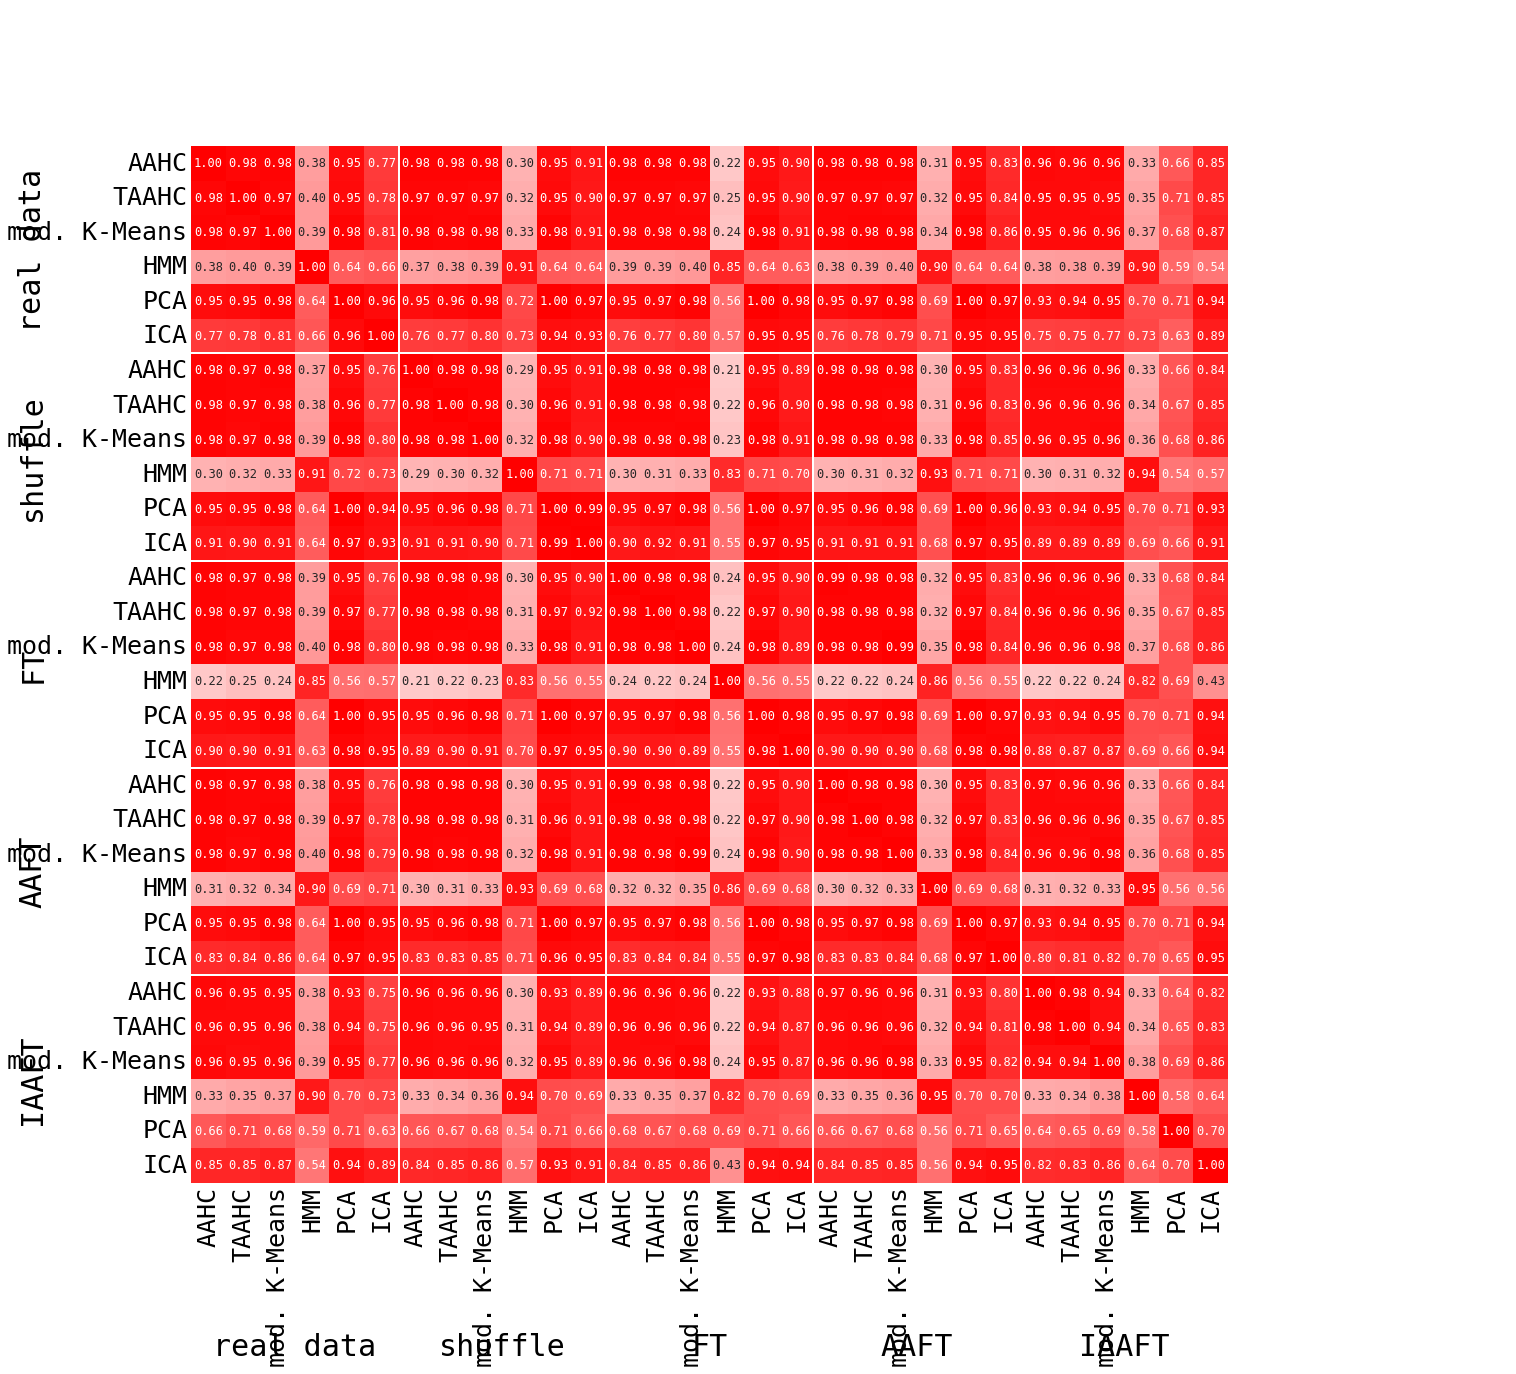

In [39]:
g5 = pw.Brick("ax54", figsize=(18, 18))
sns.heatmap(
    mean,
    square=True,
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    cmap="bwr",
    cbar_kws={"shrink": 0.7, "label": "Topographies // Pearson"},
    ax=g5,
)
for line in np.arange(6, mean.shape[0], 6):
    g5.axes.axhline(line, color="w")
    g5.axes.axvline(line, color="w")
for pos, method in enumerate(DATA_ORDER):
    g5.axes.text(-5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g5.axes.text(3 + 6 * pos, 35, method, size=30, ha="center")
# g5.text(
#     -0.1,
#     1.05,
#     "E",
#     ha="center",
#     va="center",
#     transform=g5.transAxes,
#     fontsize=70,
# )
g5.savefig(quick=True)

In [14]:
# segmentations = (
#     xr.open_dataarray(os.path.join(FOLDER, "segmentations.nc"))
#     .squeeze()
#     .sel({"data_type": EOC})
#     .rename({"decomposition_type": "algorithm"})
# )
# rename_algs = {
#     "AAHC": "AAHC",
#     "TAAHC": "TAAHC",
#     "ICA": "ICA",
#     "PCA": "PCA",
#     "hmm": "HMM",
#     "kmeans": "mod. K-Means",
# }
# segmentations["algorithm"] = [
#     rename_algs[str(alg.values)] for alg in segmentations["algorithm"]
# ]
# segmentations = segmentations.stack(algo_surr=("surrogate_type", "algorithm"))

In [15]:
# segm_df = segmentations.to_series().reset_index().rename(columns={0: "segmentation"})

In [16]:
# segm_corrs = (
#     segm_df.pivot(
#         index=["subject_id", "time"],
#         columns=["surrogate_type", "algorithm"],
#         values="segmentation",
#     )
#     .groupby("subject_id")
#     .corr("spearman")
#     .unstack()
# )

In [26]:
# segm_df = segm_corrs.groupby("surrogate_type").mean().unstack().to_frame()
# segm_df.index.names = ["surrogate_type1", "algorithm1", "algorithm2", "surrogate_type2"]
# segm_df = segm_df.rename(columns={0: "spearman"}).reset_index().pivot(index=["surrogate_type1", "algorithm1"], columns=["surrogate_type2", "algorithm2"], values="spearman")
# segm_df.index.name = ""
# segm_df.columns.name = ""
# segm_df = segm_df.rename(
#     columns={"real_data": "real data"}, index={"real_data": "real data"}, level=0
# )

# multicol_order = [(data, algo) for data in DATA_ORDER for algo in COLUMNS_ORDER]
# segm_df = segm_df.loc[multicol_order, multicol_order]
# segm_df.columns = segm_df.columns.droplevel(0)
# segm_df.index = segm_df.index.droplevel(0)
segm_df = pd.read_csv("segm_df.csv", index_col=0)

In [33]:
segm_df.columns = ['AAHC', 'TAAHC', 'mod. K-Means', 'HMM', 'PCA', 'ICA']*5

In [34]:
segm_df

,AAHC,TAAHC,mod. K-Means,HMM,PCA,ICA,AAHC,TAAHC,mod. K-Means,HMM,...,mod. K-Means,HMM,PCA,ICA,AAHC,TAAHC,mod. K-Means,HMM,PCA,ICA
algorithm1,,,,,,,,,,,,,,,,,,,,,
AAHC,1.000000,0.359336,0.351266,0.001938,0.181166,0.151713,0.005249,0.006501,0.004801,0.003910,...,0.004997,0.004282,0.004619,0.004040,0.005820,0.006175,0.005365,0.005981,0.004355,0.004192
TAAHC,0.359336,1.000000,0.332267,0.003045,0.159066,0.127450,0.004709,0.006278,0.005265,0.003986,...,0.004780,0.004960,0.004922,0.004190,0.005536,0.005111,0.005301,0.005866,0.004922,0.004564
mod. K-Means,0.351266,0.332267,1.000000,0.010863,0.249183,0.167252,0.003233,0.003951,0.006357,0.004601,...,0.006138,0.004874,0.005829,0.006298,0.004318,0.003524,0.005658,0.006853,0.005345,0.005286
HMM,0.001938,0.003045,0.010863,1.000000,0.015731,0.015391,0.003904,0.003407,0.005366,0.004697,...,0.004961,0.003975,0.004177,0.005060,0.002953,0.003780,0.004031,0.004754,0.003806,0.004267
PCA,0.181166,0.159066,0.249183,0.015731,1.000000,0.154598,0.003379,0.003605,0.006582,0.003891,...,0.005588,0.005377,0.005376,0.005846,0.004224,0.004323,0.005653,0.006320,0.005577,0.005683
ICA,0.151713,0.127450,0.167252,0.015391,0.154598,1.000000,0.004451,0.004637,0.007248,0.004274,...,0.006643,0.005077,0.005991,0.006334,0.004546,0.004556,0.006485,0.005641,0.006134,0.005546
AAHC,0.005249,0.004709,0.003233,0.003904,0.003379,0.004451,1.000000,0.374879,0.004324,0.004479,...,0.005432,0.003438,0.004871,0.004504,0.005925,0.005689,0.005106,0.004833,0.005582,0.005245
TAAHC,0.006501,0.006278,0.003951,0.003407,0.003605,0.004637,0.374879,1.000000,0.004425,0.004734,...,0.005405,0.003945,0.005027,0.004985,0.006467,0.005638,0.005099,0.005879,0.005417,0.004803
mod. K-Means,0.004801,0.005265,0.006357,0.005366,0.006582,0.007248,0.004324,0.004425,1.000000,0.006772,...,0.006152,0.004876,0.005294,0.005844,0.005292,0.005461,0.005548,0.006783,0.005152,0.005751


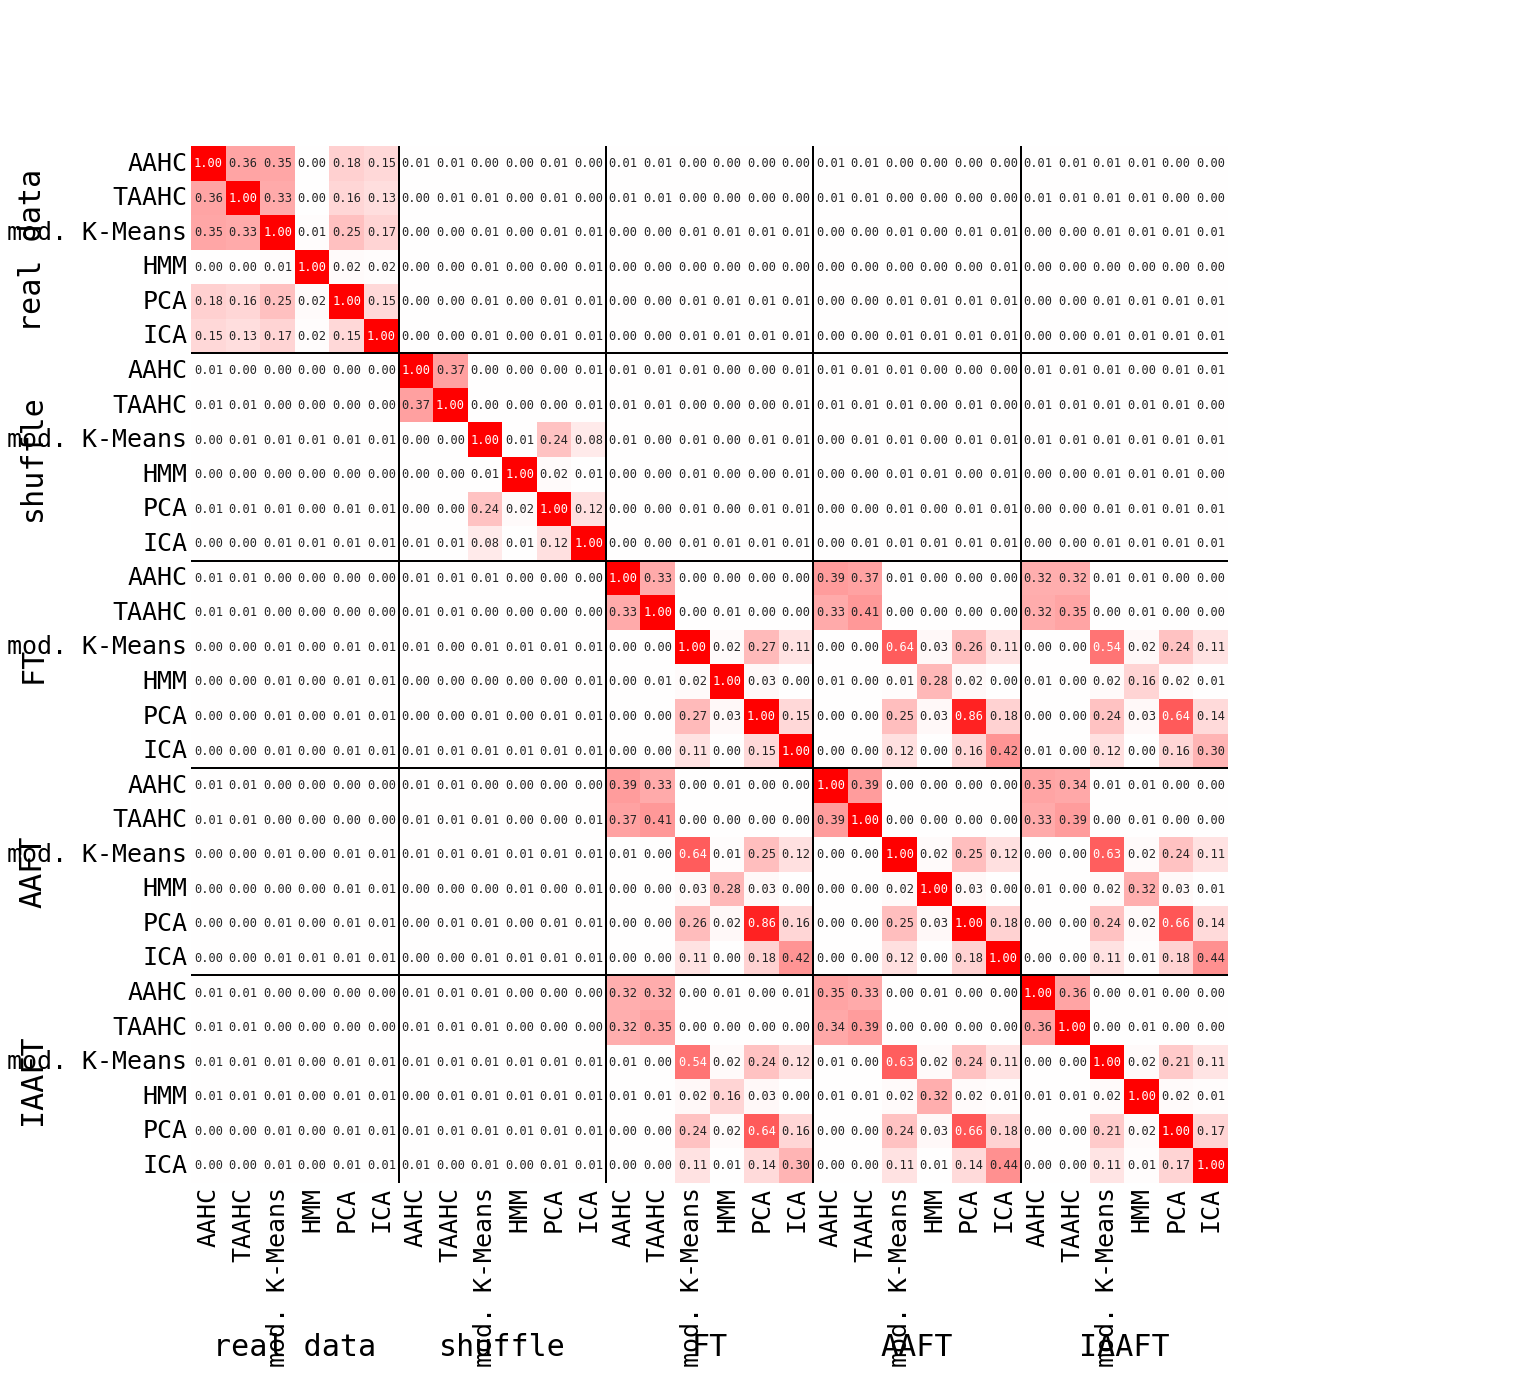

In [37]:
g6 = pw.Brick("ax18", figsize=(18, 18))
sns.heatmap(
    segm_df,
    square=True,
    vmin=-1,
    annot=True,
    fmt=".2f",
    vmax=1,
    cmap="bwr",
    cbar_kws={"shrink": 0.7, "label": "Segmentation // Spearman"},
    ax=g6,
)
g6.set_ylabel("")
for line in np.arange(6, mean.shape[0], 6):
    g6.axes.axhline(line, color="k")
    g6.axes.axvline(line, color="k")
for pos, method in enumerate(DATA_ORDER):
    g6.axes.text(-5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g6.axes.text(3 + 6 * pos, 35, method, size=30, ha="center")
# g6.text(
#     -0.1,
#     1.05,
#     "F",
#     ha="center",
#     va="center",
#     transform=g6.transAxes,
#     fontsize=70,
# )
g6.savefig(quick=True)

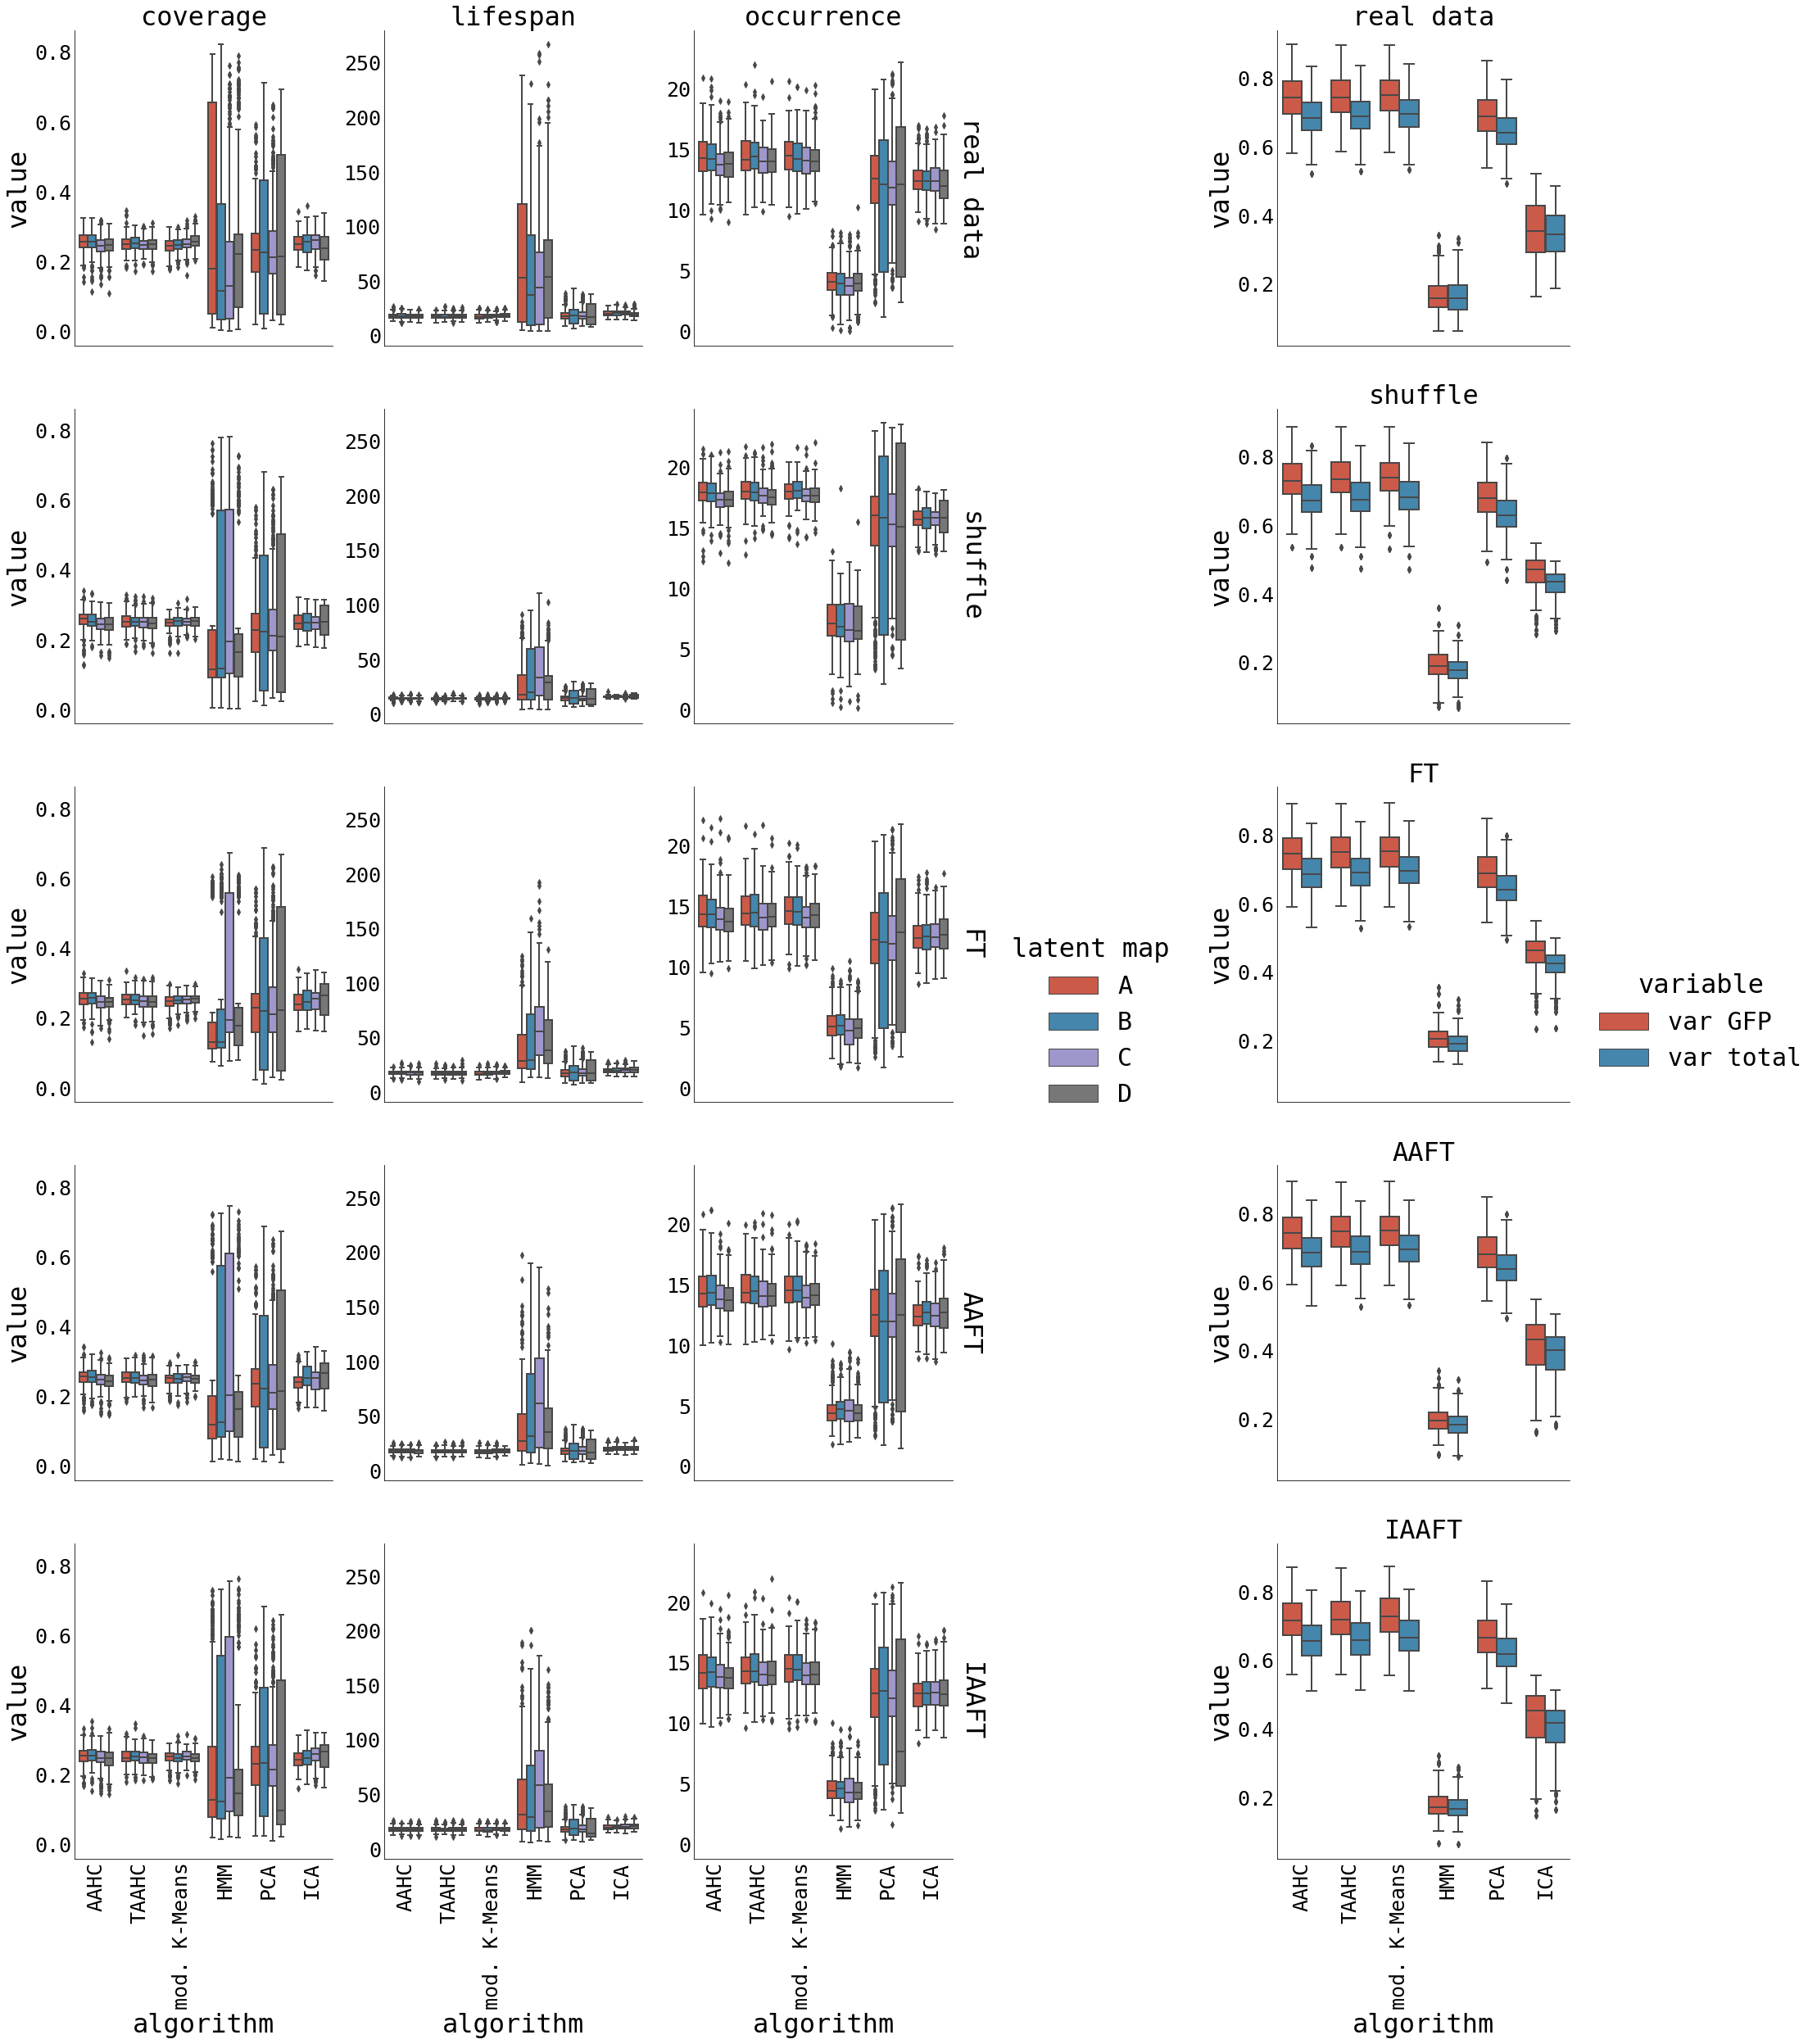

In [20]:
((g1 | g2)).savefig(f"LEMON_surrs_{EOC}_static_stats.pdf", transparent=True)

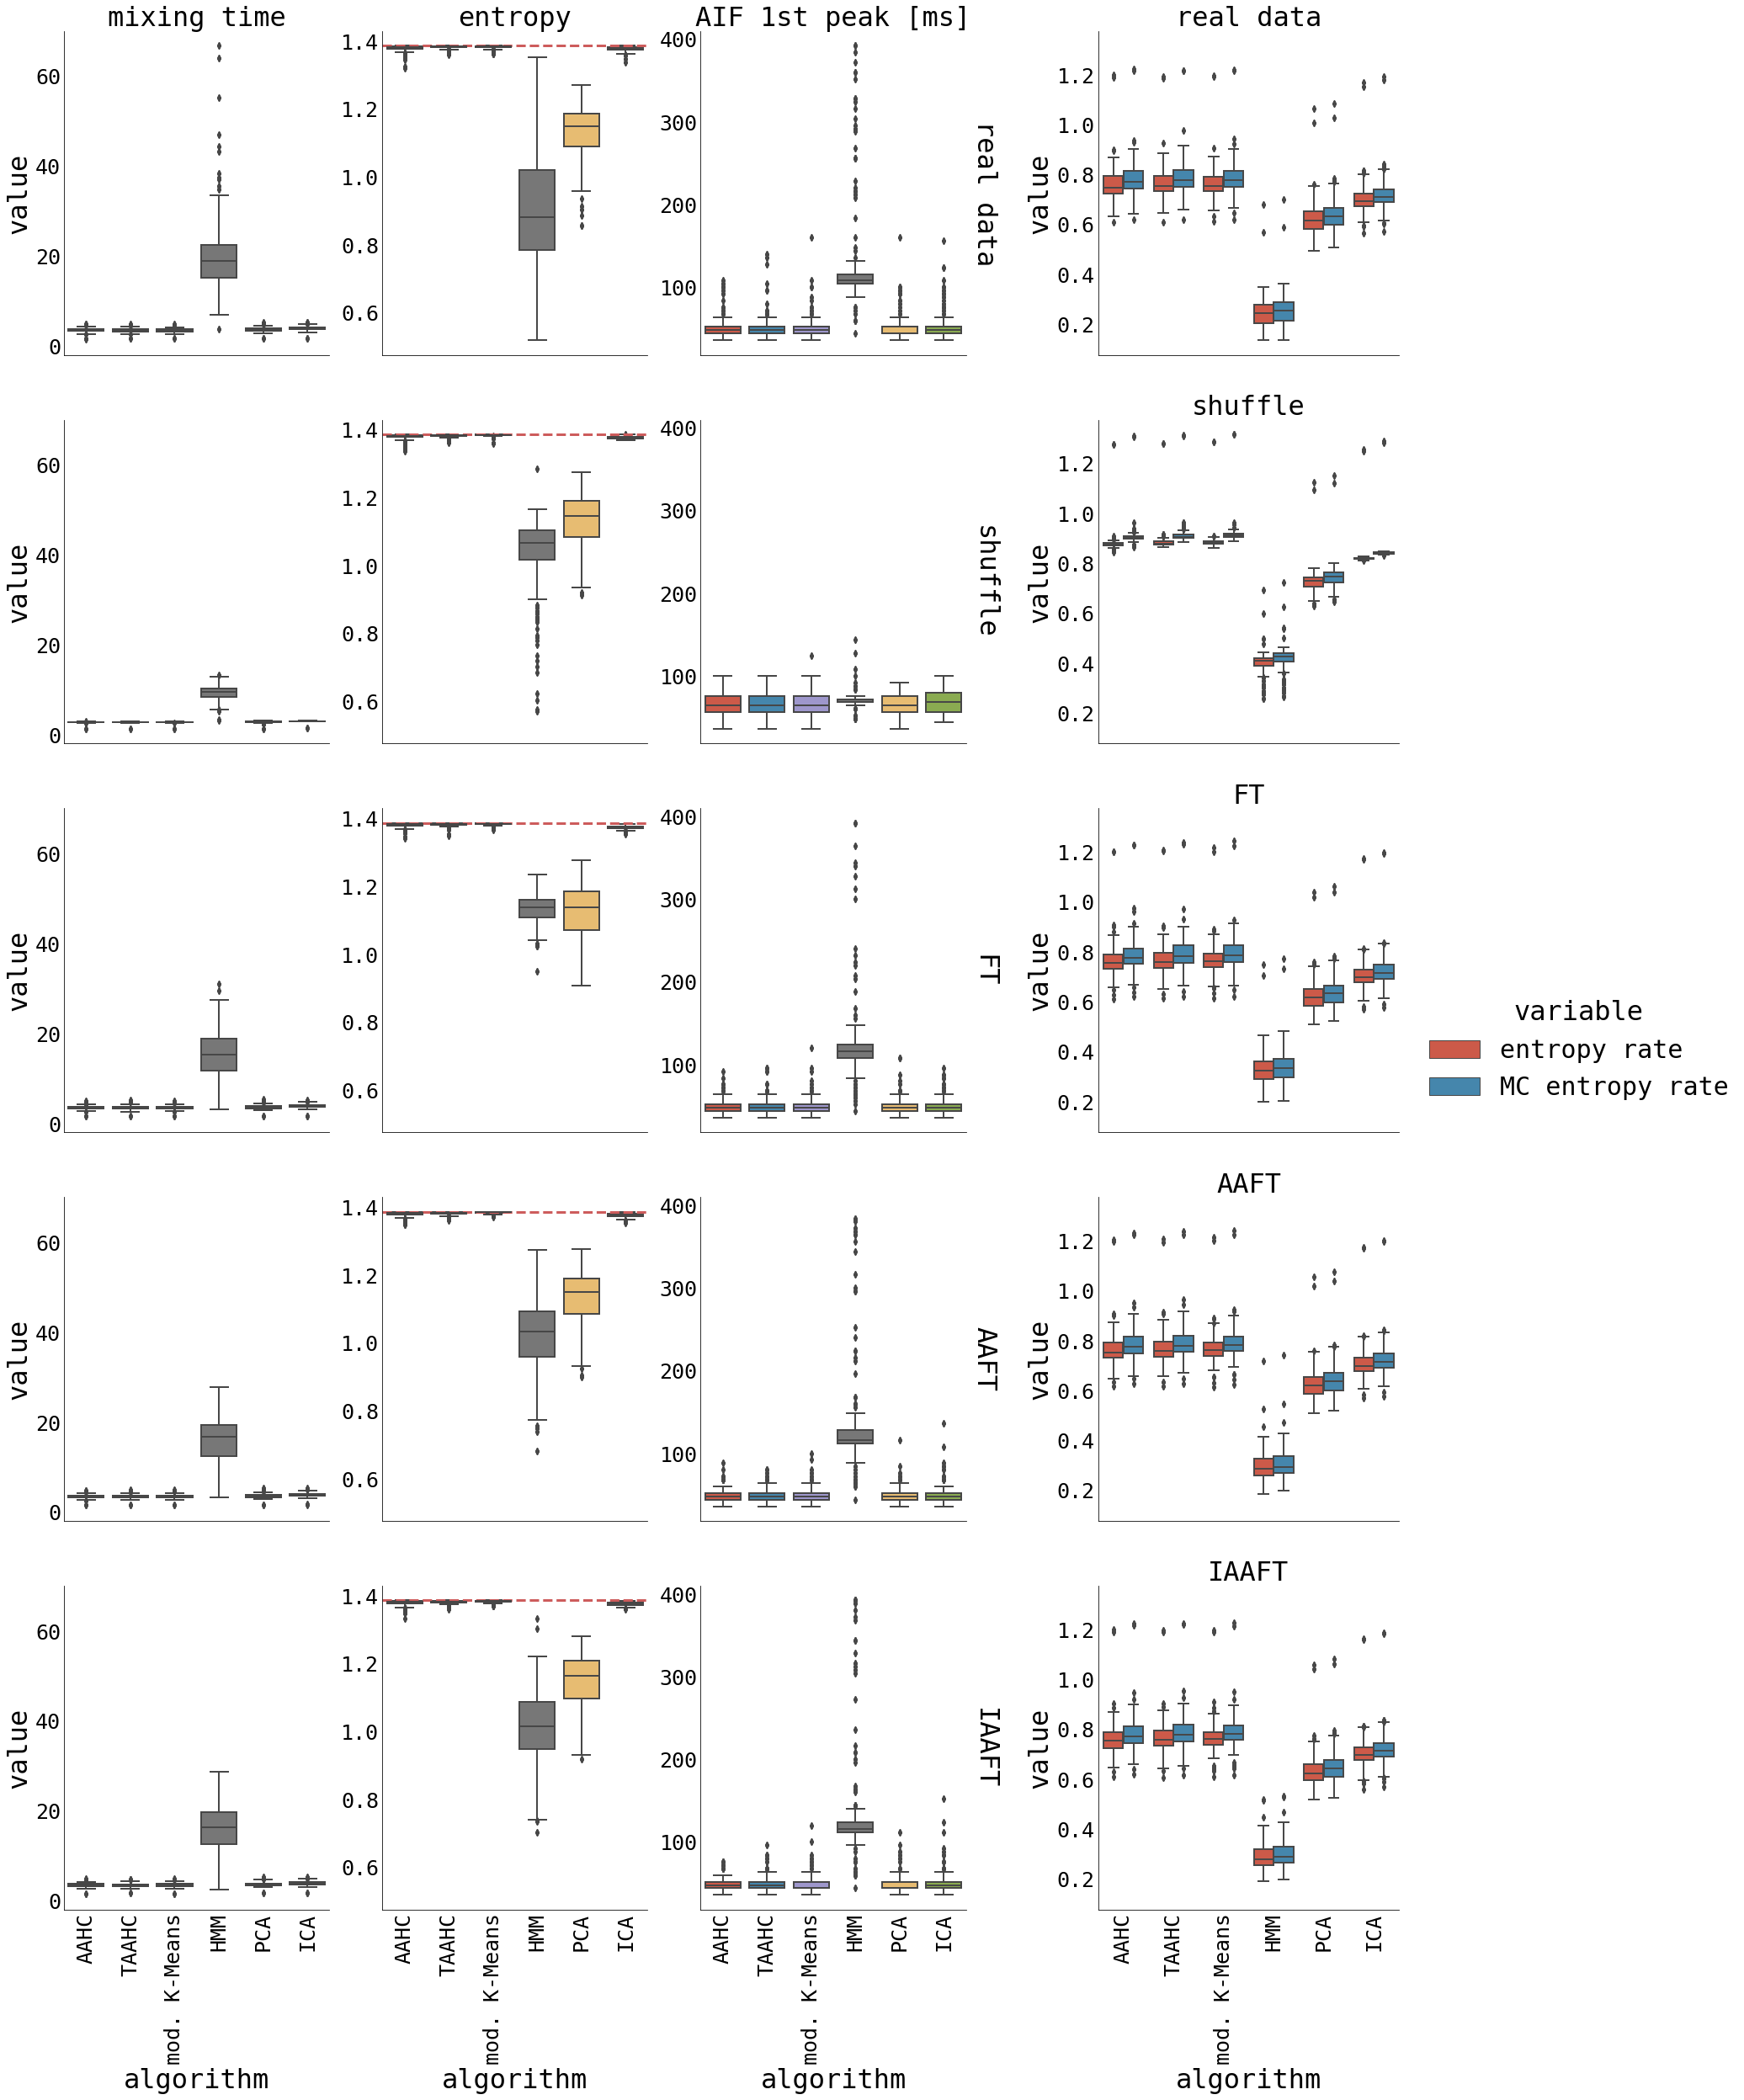

In [21]:
((g3 | g4)).savefig(f"LEMON_surrs_{EOC}_info_stats.pdf", transparent=True)

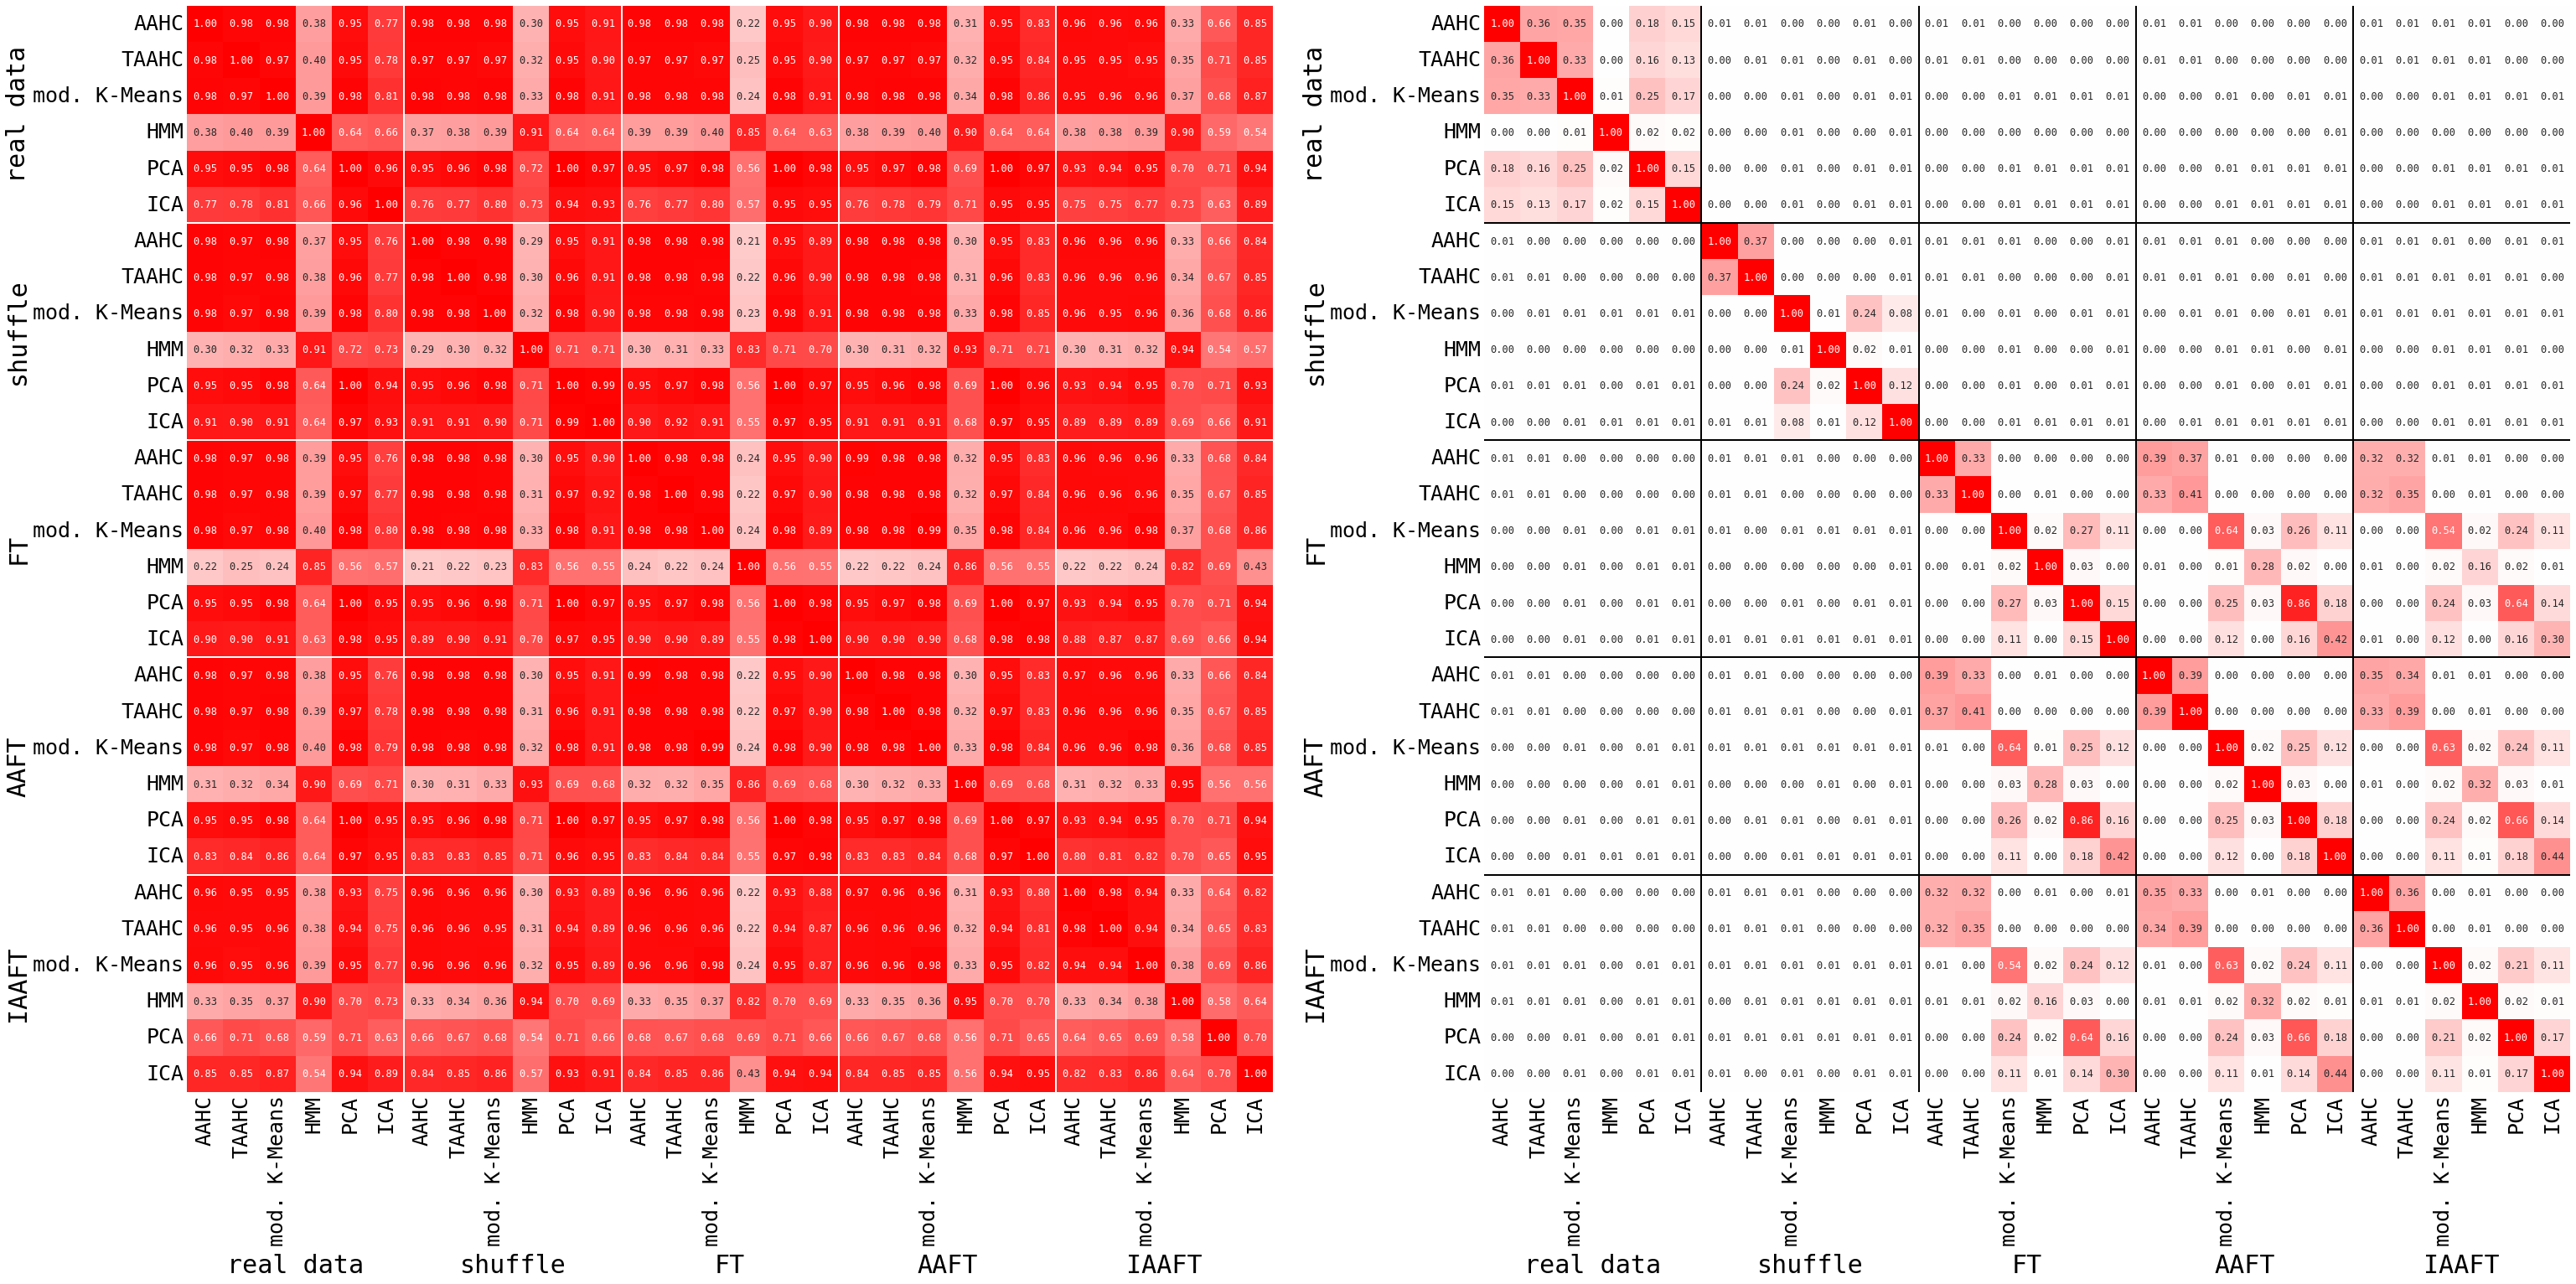

In [40]:
((g5 | g6)).savefig(f"LEMON_surrs_{EOC}_matrices.pdf", transparent=True)